In [53]:
import numpy as np
from datetime import timedelta
import pandas as pd
from pandas.plotting import lag_plot, autocorrelation_plot
from datetime import date

import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import matplotlib as mpl

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
import statsmodels.api as smw
from statsmodels.tsa.statespace.sarimax import SARIMAX

from scipy.signal import savgol_filter
import sklearn
from sklearn import preprocessing as pp
from sklearn.decomposition import PCA
from sklearn.svm import SVR
from sklearn.metrics import r2_score

import tensorflow as tf
from tensorflow import keras
from keras import optimizers, models, layers, regularizers
import keras_tuner as kt
tf.__version__

'2.6.0'

In [54]:
%load_ext skip_kernel_extension

The skip_kernel_extension extension is already loaded. To reload it, use:
  %reload_ext skip_kernel_extension


In [55]:
from utils.dde_preprocessing_utils import (set_timestamp_index,
remove_duplicates,
remove_columns,
extract_correlations,
prepare_data_sarimax,
create_test_train_split,
create_sarimax_test_train_split,
create_eval_df,
convert_to_sample_time_feature,
convert_from_differencing,
make_multiple_predictions,
calculate_r2_scores,
apply_differencing,
create_split,
apply_savgol_filter)
from utils.dde_plotting_utils import(
display_double_timestamps,
display_seasonal_decomposition,
plot_predictions,
plot_accuracy,
plot_error_variations,
plot_learning_curves,
plot_multiple_predictions,
plot_evaluation
)

In [56]:
config = tf.compat.v1.ConfigProto(gpu_options=tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.8))
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)
tf.compat.v1.keras.backend.set_session(session)
mpl.rcParams['figure.figsize'] = [16.0, 8.0]
tf.random.set_seed(2022)

In [57]:
SKIP_RETRAIN_NN =True
SKIP_RETRAIN_RNN = True
SKIP_RETRAIN_LSTM = True
SKIP_RETRAIN_ED_LSTM = False

## Loading Data

Benchmark data set

In [58]:
bench_df = pd.read_csv("energy_dataset.csv")
bench_df = set_timestamp_index(bench_df,"time")
bench_df = bench_df['price day ahead']
bench_df = bench_df.rename('Benchmark')

Base data set

In [59]:
base_df = pd.read_csv("extended_preprocessed_data3.csv")
base_df = set_timestamp_index(base_df,"Unnamed: 0")

In [60]:
base_df

,temp,pressure,humidity,wind_speed,wind_deg,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,...,share other renewable,share solar,share waste,share wind onshore,month,day,weekend,hour,energy_exchange_PT,energy_exchange_FR
2015-01-01 00:00:00+01:00,-2.675,1001.0,77,1.0,62,447.0,329.0,4844.0,4821.0,162.0,...,0.002584,0.001734,0.006938,0.225762,1,1,0,0,-285.0,933.0
2015-01-01 01:00:00+01:00,-2.675,1001.0,77,1.0,62,449.0,328.0,5196.0,4755.0,158.0,...,0.002552,0.001797,0.007010,0.211733,1,1,0,1,53.0,1119.0
2015-01-01 02:00:00+01:00,-3.464,1002.0,78,0.0,23,448.0,323.0,4857.0,4581.0,157.0,...,0.002724,0.001866,0.007315,0.203799,1,1,0,2,682.0,954.0
2015-01-01 03:00:00+01:00,-3.464,1002.0,78,0.0,23,438.0,254.0,4314.0,4131.0,160.0,...,0.002973,0.001982,0.007572,0.207668,1,1,0,3,976.0,13.0
2015-01-01 04:00:00+01:00,-3.464,1002.0,78,0.0,23,428.0,187.0,4130.0,3840.0,156.0,...,0.003006,0.001706,0.007677,0.200447,1,1,0,4,1011.0,-238.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 19:00:00+01:00,12.490,1028.0,62,2.0,140,297.0,0.0,7634.0,2628.0,178.0,...,0.003596,0.003218,0.010486,0.117850,12,31,0,19,-1102.0,-3232.0
2018-12-31 20:00:00+01:00,9.990,1029.0,71,1.0,242,296.0,0.0,7241.0,2566.0,174.0,...,0.003768,0.001309,0.011105,0.130409,12,31,0,20,-1099.0,-3377.0
2018-12-31 21:00:00+01:00,8.510,1029.0,81,3.0,300,292.0,0.0,7025.0,2422.0,168.0,...,0.003919,0.001292,0.011923,0.146037,12,31,0,21,-1329.0,-3460.0
2018-12-31 22:00:00+01:00,6.990,1029.0,81,2.0,310,293.0,0.0,6562.0,2293.0,163.0,...,0.004088,0.001363,0.012616,0.157640,12,31,0,22,-937.0,-3429.0


Apply Savitzky Golay Filter 

In [61]:
savgol_df = apply_savgol_filter(base_df,7,3,excluded=['month','day','weekend','hour'])

In [62]:
savgol_df

,temp,pressure,humidity,wind_speed,wind_deg,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,...,share other renewable,share solar,share waste,share wind onshore,energy_exchange_PT,energy_exchange_FR,month,day,weekend,hour
2015-01-01 00:00:00+01:00,-2.552214,1000.976190,76.547619,1.214286,80.833333,446.357143,326.238095,4904.809524,4825.595238,161.380952,...,0.002558,0.001693,0.006911,0.224937,-330.190476,950.785714,1,1,0,0
2015-01-01 01:00:00+01:00,-3.000071,1001.214286,77.857143,0.500000,26.785714,450.595238,339.285714,5058.238095,4761.357143,159.190476,...,0.002609,0.001877,0.007078,0.212767,181.833333,1111.047619,1,1,0,1
2015-01-01 02:00:00+01:00,-3.281857,1001.571429,78.214286,0.142857,12.857143,447.166667,308.357143,4856.166667,4526.071429,157.833333,...,0.002734,0.001912,0.007294,0.206465,602.619048,822.333333,1,1,0,2
2015-01-01 03:00:00+01:00,-3.397571,1002.047619,77.619048,0.142857,39.047619,438.238095,254.952381,4478.761905,4195.238095,157.142857,...,0.002888,0.001838,0.007515,0.203164,909.000000,263.476190,1,1,0,3
2015-01-01 04:00:00+01:00,-3.337143,1002.761905,75.761905,0.571429,118.619048,424.619048,208.857143,4155.285714,3863.190476,157.000000,...,0.003020,0.001692,0.007661,0.199622,1114.238095,-370.666667,1,1,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 19:00:00+01:00,12.996190,1028.333333,59.380952,2.190476,172.952381,295.095238,0.000000,7538.619048,2611.380952,176.714286,...,0.003662,0.000811,0.011006,0.121642,-1206.428571,-2611.190476,12,31,0,19
2018-12-31 20:00:00+01:00,10.139048,1028.666667,72.571429,2.000000,226.857143,294.666667,0.000000,7308.095238,2545.476190,173.190476,...,0.003741,-0.001913,0.011150,0.132491,-1499.761905,-3041.952381,12,31,0,20
2018-12-31 21:00:00+01:00,8.343571,1029.023810,80.071429,2.095238,291.523810,294.000000,0.000000,6891.500000,2434.690476,168.023810,...,0.003941,0.001806,0.011876,0.145105,-1156.071429,-3647.690476,12,31,0,21
2018-12-31 22:00:00+01:00,7.020714,1029.166667,81.357143,2.166667,324.809524,292.571429,0.000000,6662.214286,2300.833333,163.880952,...,0.004086,0.004705,0.012534,0.155878,-636.714286,-3831.904762,12,31,0,22


Apply Differencing 

In [63]:
diff_df = apply_differencing(savgol_df,['month','day','weekend','hour'])
diff_df.index = diff_df.index.tz_convert('utc')
# diff_df = apply_savgol_filter(base_df,7,3,deriv=1,excluded=['month','day','weekend','hour'])

In [64]:
diff_df

,temp,pressure,humidity,wind_speed,wind_deg,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,...,share other renewable,share solar,share waste,share wind onshore,energy_exchange_PT,energy_exchange_FR,month,day,weekend,hour
2015-01-01 00:00:00+00:00,-0.447857,0.238095,1.309524,-7.142857e-01,-54.047619,4.238095,13.047619,153.428571,-64.238095,-2.190476,...,0.000051,0.000184,0.000168,-0.012170,512.023810,160.261905,1,1,0,1
2015-01-01 01:00:00+00:00,-0.281786,0.357143,0.357143,-3.571429e-01,-13.928571,-3.428571,-30.928571,-202.071429,-235.285714,-1.357143,...,0.000125,0.000035,0.000216,-0.006303,420.785714,-288.714286,1,1,0,2
2015-01-01 02:00:00+00:00,-0.115714,0.476190,-0.595238,-1.443290e-15,26.190476,-8.928571,-53.404762,-377.404762,-330.833333,-0.690476,...,0.000154,-0.000074,0.000221,-0.003301,306.380952,-558.857143,1,1,0,3
2015-01-01 03:00:00+00:00,0.060429,0.714286,-1.857143,4.285714e-01,79.571429,-13.619048,-46.095238,-323.476190,-332.047619,-0.142857,...,0.000132,-0.000145,0.000146,-0.003542,205.238095,-634.142857,1,1,0,4
2015-01-01 04:00:00+00:00,-0.133238,0.476190,-2.428571,8.571429e-01,104.380952,-12.238095,-33.714286,-131.476190,-312.571429,0.142857,...,0.000049,-0.000232,0.000074,-0.006430,-116.714286,-531.095238,1,1,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 18:00:00+00:00,-3.331905,0.285714,15.666667,-2.380952e-01,26.000000,-1.809524,0.000000,164.285714,-0.761905,-1.380952,...,-0.000059,-0.022224,-0.000320,0.009975,-625.095238,-159.476190,12,31,0,19
2018-12-31 19:00:00+00:00,-2.857143,0.333333,13.190476,-1.904762e-01,53.904762,-0.428571,0.000000,-230.523810,-65.904762,-3.523810,...,0.000079,-0.002724,0.000145,0.010849,-293.333333,-430.761905,12,31,0,20
2018-12-31 20:00:00+00:00,-1.795476,0.357143,7.500000,9.523810e-02,64.666667,-0.666667,0.000000,-416.595238,-110.785714,-5.166667,...,0.000200,0.003719,0.000726,0.012614,343.690476,-605.738095,12,31,0,21
2018-12-31 21:00:00+00:00,-1.322857,0.142857,1.285714,7.142857e-02,33.285714,-1.428571,0.000000,-229.285714,-133.857143,-4.142857,...,0.000146,0.002899,0.000657,0.010773,519.357143,-184.214286,12,31,0,22


In [65]:
diff_df.index = diff_df.index.tz_convert('utc')
base_df.index = base_df.index.tz_convert('utc')
bench_df.index = bench_df.index.tz_convert('utc')

# Encode- Decoder + LSTM

Scale the input data

In [66]:
scaled_df = diff_df.copy(deep=True)
featuresToScale = scaled_df.columns
sX = pp.MinMaxScaler(feature_range=(-1,1),copy=True)
sY = pp.StandardScaler(copy=True)

scaled_df.loc[:,featuresToScale] = sX.fit_transform(scaled_df[featuresToScale])
# scaled_df.loc[:,featuresToScale] = sX.fit_transform(scaled_df[featuresToScale])

Create Train Validation Test Split

In [67]:
train_start = '2015-01-01'
validation_start = '2018-10-01'
test_start = '2018-11-01'
test_end = '2018-12-01'
feature = 'price actual'
namespace= 'MS_LSTM_Price2'
modeltype = 'LSTM'

batch_size = 64
num_epochs = 40

feature_df = diff_df[[feature]]

data_x_train0, data_y_train0 = create_split(scaled_df,feature_df,train_start,validation_start)
data_x_val0, data_y_val0 = create_split(scaled_df,feature_df,validation_start,test_start)
data_x_test0, data_y_test0 = create_split(scaled_df,feature_df,test_start,test_end)

Convert to (sample,timestep,feature) format

In [68]:
data_x_train,data_y_train,idx_train = convert_to_sample_time_feature(data_x_train0,data_y_train0,24*14,24,batch_size)
data_x_test,data_y_test,idx_test = convert_to_sample_time_feature(data_x_test0,data_y_test0,24*14,24,batch_size)
data_x_val,data_y_val,idx_val = convert_to_sample_time_feature(data_x_val0,data_y_val0,24*14,24,batch_size)


In [69]:
print(data_x_train.shape,data_y_train.shape,idx_train.shape)
print(data_x_val.shape,data_y_val.shape,idx_val.shape)
print(data_x_test.shape,data_y_test.shape,idx_test.shape)

(32448, 336, 44) (32448, 24) (32448,)
(320, 336, 44) (320, 24) (320,)
(320, 336, 44) (320, 24) (320,)


Define LSTM Model

In [70]:
def build_model_ED_LSTM():
    n_timesteps, n_features, n_outputs = data_x_train.shape[1], data_x_train.shape[2], data_y_train.shape[1]
    model = models.Sequential([
    layers.LSTM(64, return_sequences=True,input_shape=(None, n_features), stateful=False), 
    layers.BatchNormalization(),
    
    layers.LSTM(64, return_sequences=True, stateful=False),
    layers.BatchNormalization(),
    layers.LSTM(64, return_sequences=True, stateful=False),
    layers.BatchNormalization(),
    
    layers.LSTM(64, stateful=False),
    layers.BatchNormalization(),
    
    layers.Dense(64, kernel_regularizer=regularizers.l2(0.001), kernel_initializer="he_normal"),
    layers.Dense(32, kernel_regularizer=regularizers.l2(0.001), kernel_initializer="he_normal"),
    layers.ELU(alpha=0.1),
    layers.BatchNormalization(),
    layers.Dense(n_outputs)                     
    ])               
                
    model.compile(optimizer='Adam',loss='mse',metrics='mae') 
    return model

In [71]:
myCheckpointLSTM= keras.callbacks.ModelCheckpoint(f"./{modeltype}/my_best_model_{namespace}.h5", save_best_only=True)
myEarly_stoppingLSTM = keras.callbacks.EarlyStopping(patience=20,restore_best_weights=True)

In [72]:
initial_learning_rate = 0.001

decay = initial_learning_rate/num_epochs

def scheduler(epoch,lr):
    return lr*1/(1+decay*epoch)

myLearningRate_LSTM = keras.callbacks.LearningRateScheduler(scheduler, verbose=1)


In [73]:
%%skip $SKIP_RETRAIN_ED_LSTM
model_ED_LSTM= build_model_ED_LSTM()
history_ED_LSTM = model_ED_LSTM.fit(data_x_train, data_y_train, epochs=num_epochs, batch_size=batch_size, validation_data=(data_x_val, data_y_val) , 
                                 callbacks=[myCheckpointLSTM,myEarly_stoppingLSTM,myLearningRate_LSTM])#

Epoch 1/40

Epoch 00001: LearningRateScheduler setting learning rate to 0.0010000000474974513.
507/507 [==============================] - 57s 100ms/step - loss: 3.9033 - mae: 1.4108 - val_loss: 2.5037 - val_mae: 1.2128
Epoch 2/40

Epoch 00002: LearningRateScheduler setting learning rate to 0.0009999750481212483.
507/507 [==============================] - 48s 95ms/step - loss: 2.2341 - mae: 1.0822 - val_loss: 1.9518 - val_mae: 1.0509
Epoch 3/40

Epoch 00003: LearningRateScheduler setting learning rate to 0.0009999250219521608.
507/507 [==============================] - 47s 92ms/step - loss: 1.9418 - mae: 1.0134 - val_loss: 1.8298 - val_mae: 1.0327
Epoch 4/40

Epoch 00004: LearningRateScheduler setting learning rate to 0.0009998500872736493.
507/507 [==============================] - 47s 93ms/step - loss: 1.7279 - mae: 0.9619 - val_loss: 1.9612 - val_mae: 1.0611
Epoch 5/40

Epoch 00005: LearningRateScheduler setting learning rate to 0.0009997501295499831.
507/507 [=======================

In [74]:
%%skip $SKIP_RETRAIN_ED_LSTM
histEDLSTM = pd.DataFrame(history_ED_LSTM.history)
histEDLSTM['epoch'] = history_ED_LSTM.epoch

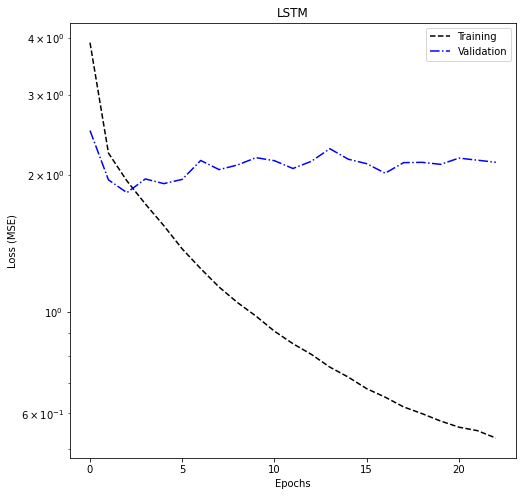

In [75]:
%%skip $SKIP_RETRAIN_ED_LSTM
fig = plot_learning_curves(histEDLSTM,modeltype,f"./{modeltype}/learningcurve_{namespace}.png")

Load best model

In [76]:
model_best_ED_LSTM = keras.models.load_model(f"./{modeltype}/my_best_model_{namespace}.h5")
model_best_ED_LSTM.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, None, 64)          27904     
_________________________________________________________________
batch_normalization_5 (Batch (None, None, 64)          256       
_________________________________________________________________
lstm_5 (LSTM)                (None, None, 64)          33024     
_________________________________________________________________
batch_normalization_6 (Batch (None, None, 64)          256       
_________________________________________________________________
lstm_6 (LSTM)                (None, None, 64)          33024     
_________________________________________________________________
batch_normalization_7 (Batch (None, None, 64)          256       
_________________________________________________________________
lstm_7 (LSTM)                (None, 64)               

Evaluate differencing performance on validation data

In [77]:
i=0
case_val = data_x_val[i].reshape((1,data_x_val[0].shape[0], data_x_val[0].shape[1]))
Y_val_predictions_diff = pd.Series(model_best_ED_LSTM.predict(case_val).flatten(),index=pd.date_range(start=idx_val[i],freq='h',periods=24))
y_val_filtered_diff = data_y_val0.loc[Y_val_predictions_diff.index]
y_val_filtered_diff = y_val_filtered_diff.squeeze(axis=1)

In [78]:
eval_df_diff = create_eval_df(Y_val_predictions_diff,y_val_filtered_diff)

R^2 score is  0.75


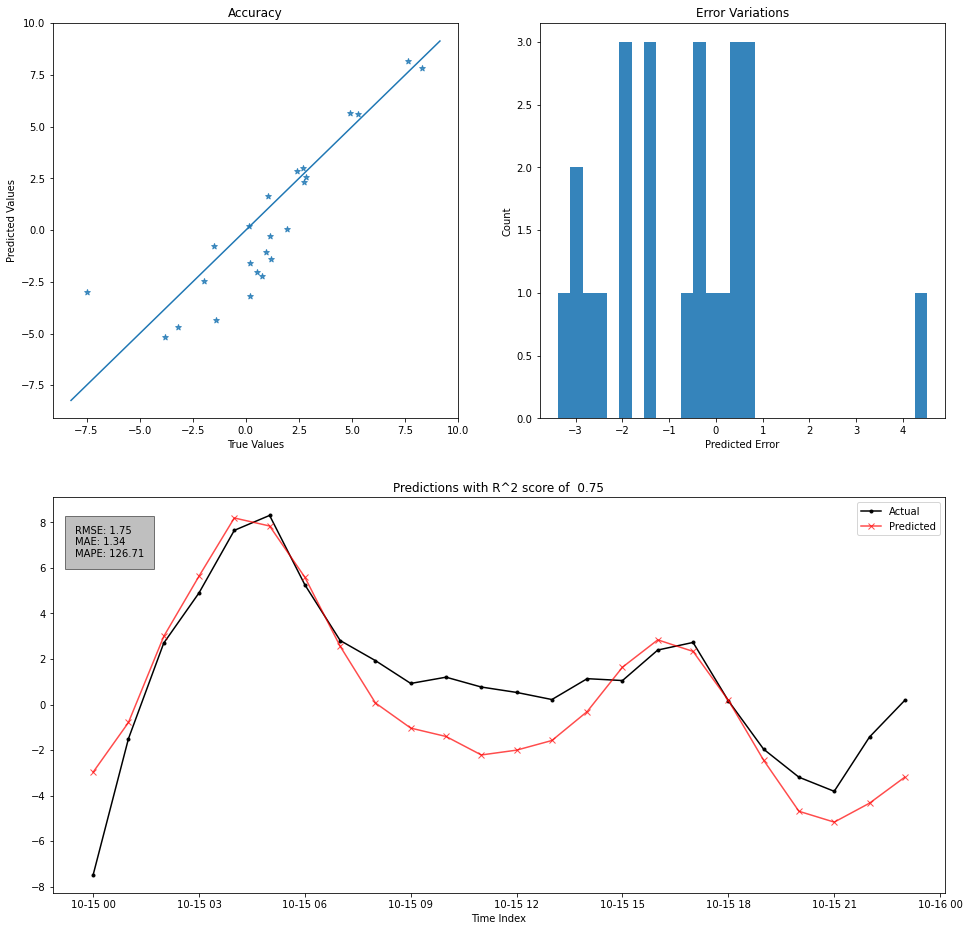

In [79]:
fig = plot_evaluation(eval_df_diff)

In [80]:
df_pred_diff = make_multiple_predictions(model_best_ED_LSTM,idx_val,data_x_val,data_y_val0,feature,convert=False)

In [81]:
eval_df_diff = create_eval_df(df_pred_diff['mean'],df_pred_diff['Actual'])

R^2 score is  0.83


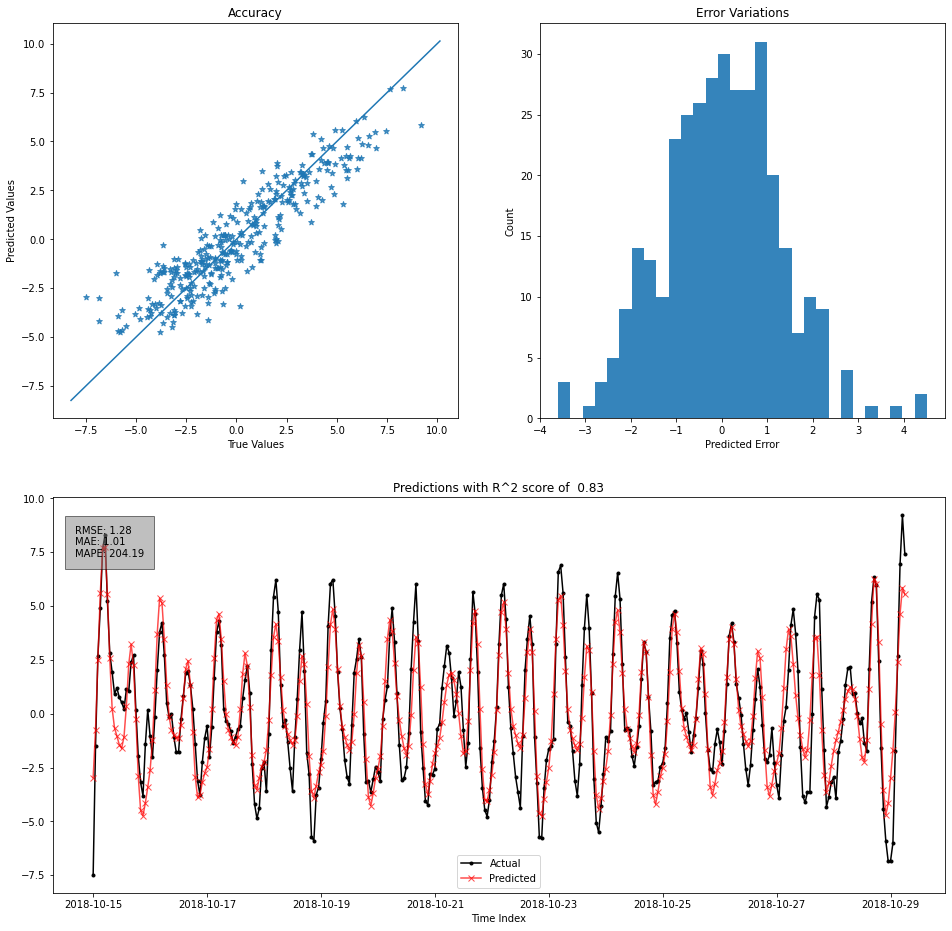

In [82]:
fig = plot_evaluation(eval_df_diff)

Reverting differencing on validation data

In [83]:
df_pred = make_multiple_predictions(model_best_ED_LSTM,idx_val,data_x_val,savgol_df,feature,convert=True)

In [84]:
eval_df = create_eval_df(df_pred['mean'],df_pred['Actual'])

R^2 score is  0.83


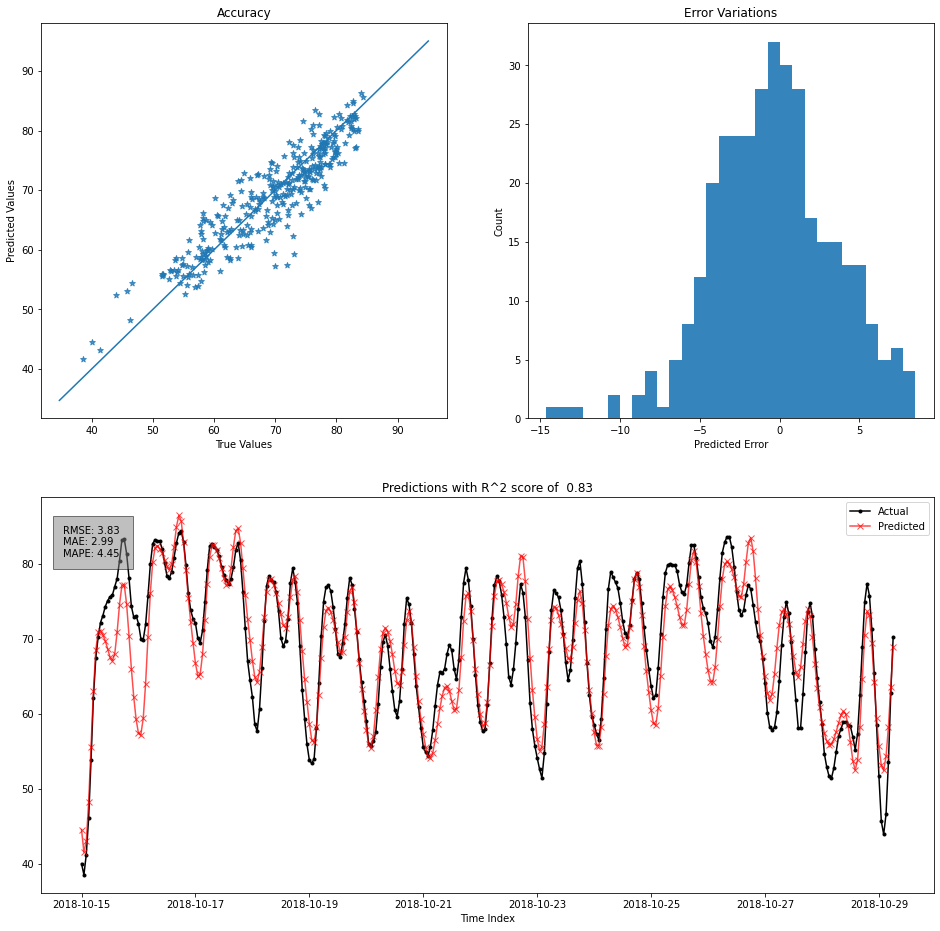

In [85]:
fig = plot_evaluation(eval_df)

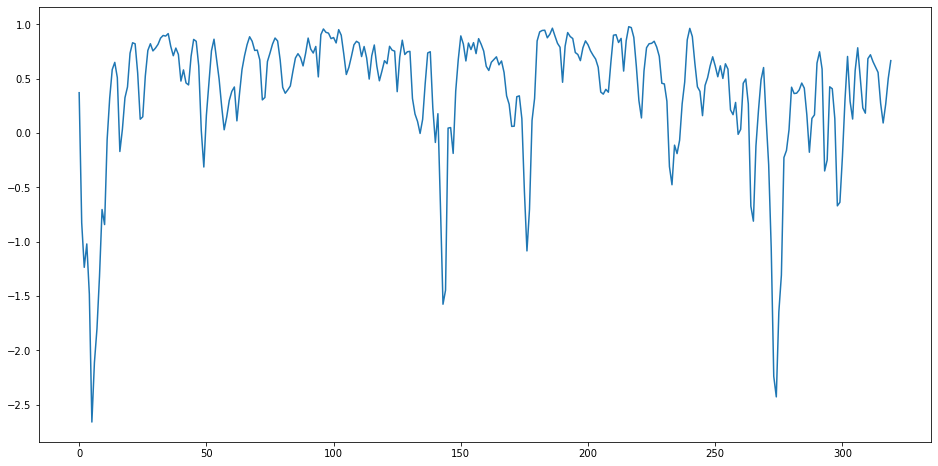

In [86]:
r2 = calculate_r2_scores(df_pred)
plt.figure()
plt.plot(r2)


Evaluate differencing Performance on test data

In [87]:
i=0
case_test = data_x_test[i].reshape((1,data_x_test[0].shape[0], data_x_test[0].shape[1]))
Y_test_predictions_diff = pd.Series(model_best_ED_LSTM.predict(case_test).flatten(),index=pd.date_range(start=idx_test[i],freq='h',periods=24))
y_test_filtered_diff = data_y_test0.loc[Y_test_predictions_diff.index]
y_test_filtered_diff = y_test_filtered_diff.squeeze(axis=1)

In [88]:
eval_df_diff = create_eval_df(Y_test_predictions_diff,y_test_filtered_diff)

R^2 score is  0.84


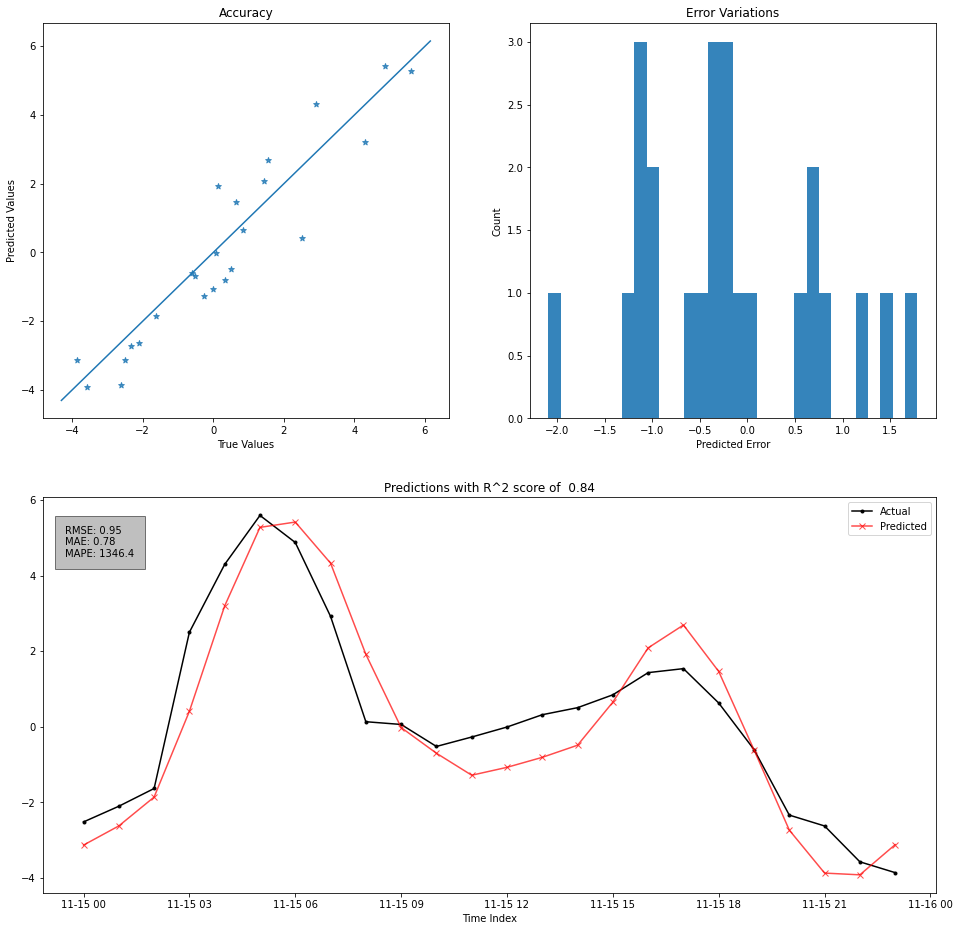

In [89]:
fig = plot_evaluation(eval_df_diff)

In [90]:
df_pred_diff = make_multiple_predictions(model_best_ED_LSTM,idx_test,data_x_test,data_y_test0,feature,convert=False)

In [91]:
eval_df_diff = create_eval_df(df_pred_diff['mean'],df_pred_diff['Actual'])

R^2 score is  0.82


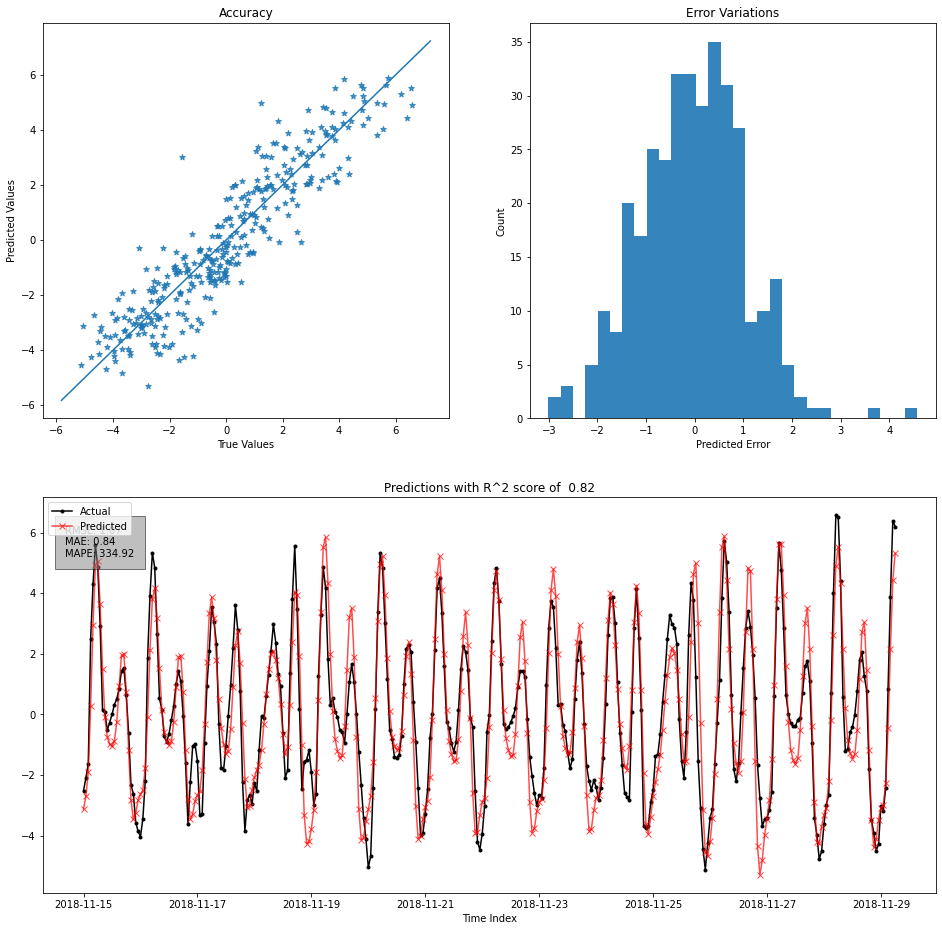

In [92]:
fig = plot_evaluation(eval_df_diff)

Reverting differencing on test data

In [93]:
df_pred = make_multiple_predictions(model_best_ED_LSTM,idx_test,data_x_test,savgol_df,feature,convert=True)

In [94]:
eval_df = create_eval_df(df_pred['mean'],df_pred['Actual'])

R^2 score is  0.81


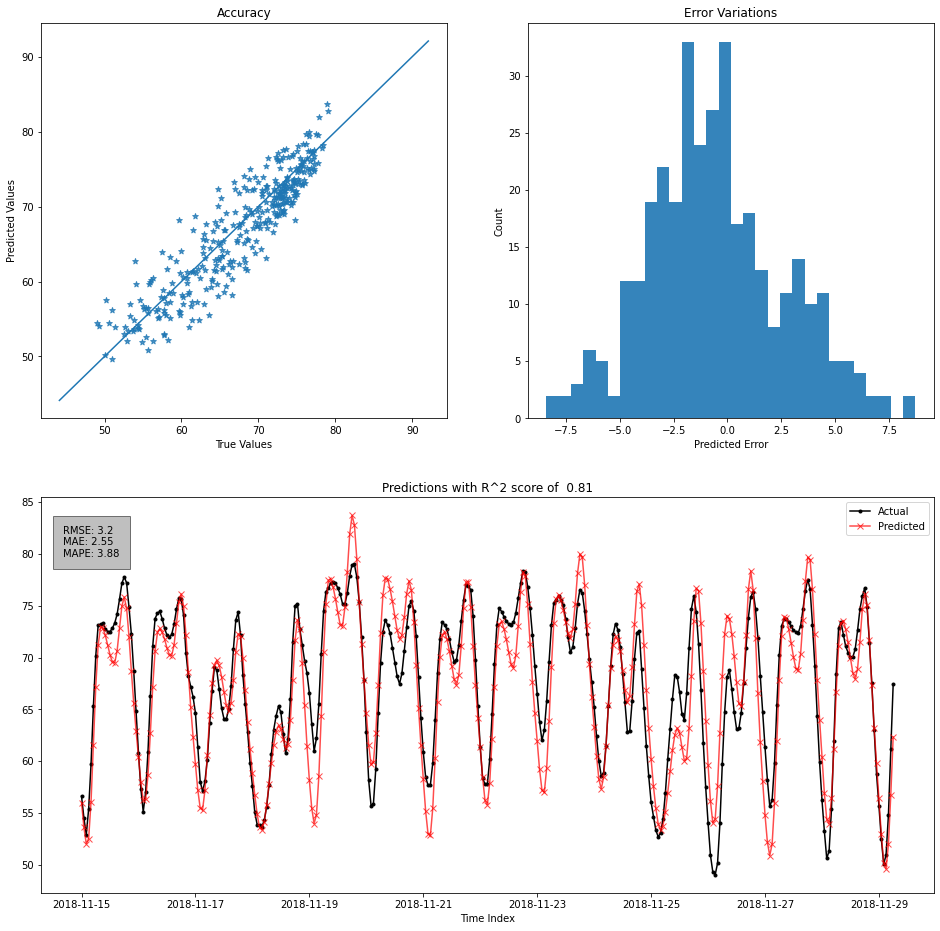

In [95]:
fig = plot_evaluation(eval_df)

In [96]:
def calculate_metrics(df_pred):
    r2_list=[]
    mpe_list= []
    mae_list= []
    for column in df_pred.columns:
        if column not in ['Actual','mean']:
            pred = df_pred[column].dropna()
            act = df_pred.loc[pred.index,'Actual']
            r2= r2_score(pred,act)
            mpe = (act-pred)/act
        
            mae = sklearn.metrics.mean_absolute_error(act,pred)
            r2_list.append(r2)
            mpe_list.append(mpe.mean())
            mae_list.append(mae)
    return r2_list,mpe_list,mae_list      

def plot_metrics(df_pred):
    fig= plt.figure(figsize = (16,16))
    gs = fig.add_gridspec(3,1)
    r2_list,mpe_list,mae_list = calculate_metrics(df_pred)
    ax1 = fig.add_subplot(gs[0,0],)
    ax2 = fig.add_subplot(gs[1,0],sharex=ax1)
    ax3 = fig.add_subplot(gs[2,0],sharex=ax1)
    ax1.plot(r2_list)
    ax1.set_title('R2 Score')
    ax2.plot(mpe_list)
    ax2.set_title('RMSE')
    ax3.plot(mae_list)
    ax3.set_title('MAE')
    ax1.set_xticks(ticks=range(0,len(r2_list),24))
    return fig


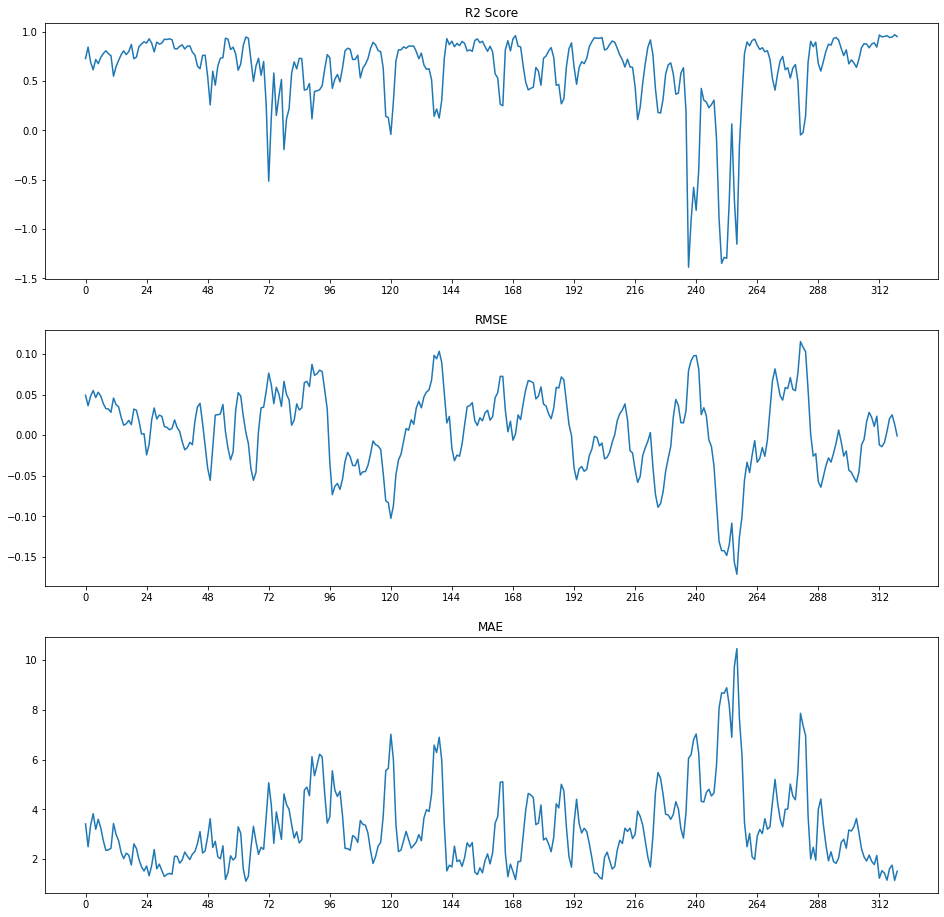

In [97]:
fig = plot_metrics(df_pred)

In [98]:
eval_df

,Prediction,Actual
2018-11-15 00:00:00+00:00,56.016878,56.630000
2018-11-15 01:00:00+00:00,53.620336,54.530476
2018-11-15 02:00:00+00:00,52.033725,52.900476
2018-11-15 03:00:00+00:00,52.541470,55.404286
2018-11-15 04:00:00+00:00,56.072832,59.702857
...,...,...
2018-11-29 02:00:00+00:00,50.220936,50.097143
2018-11-29 03:00:00+00:00,49.622342,50.937143
2018-11-29 04:00:00+00:00,51.972393,54.822381
2018-11-29 05:00:00+00:00,56.776818,61.214762


Comparing to Benchmark

In [99]:
def extend_eval_df_benchmark(eval_df,bench_df):
    bench_df=bench_df[eval_df.index]
    extended_eval_df = pd.concat([eval_df,bench_df],axis=1)
    return extended_eval_df

In [100]:
extended_eval_df = extend_eval_df_benchmark(eval_df,bench_df)
extended_eval_df

,Prediction,Actual,Benchmark
2018-11-15 00:00:00+00:00,56.016878,56.630000,51.95
2018-11-15 01:00:00+00:00,53.620336,54.530476,51.27
2018-11-15 02:00:00+00:00,52.033725,52.900476,50.29
2018-11-15 03:00:00+00:00,52.541470,55.404286,51.03
2018-11-15 04:00:00+00:00,56.072832,59.702857,53.17
...,...,...,...
2018-11-29 02:00:00+00:00,50.220936,50.097143,47.00
2018-11-29 03:00:00+00:00,49.622342,50.937143,46.67
2018-11-29 04:00:00+00:00,51.972393,54.822381,49.64
2018-11-29 05:00:00+00:00,56.776818,61.214762,58.33


In [101]:
r2_bench = r2_score(extended_eval_df['Actual'],extended_eval_df['Benchmark'],)
print('R^2 score is  %3.2f' %r2_bench)

R^2 score is  0.58


In [102]:
r2_test = r2_score(extended_eval_df['Actual'], extended_eval_df['Prediction'])
print('R^2 score is  %3.2f' %r2_test)

R^2 score is  0.81


In [108]:
df_pred_24h = df_pred.iloc[:,0::24]
df_pred_24h['total'] = df_pred_24h.mean(axis=1)


In [113]:
r2_24h = r2_score(extended_eval_df['Actual'][:-7],df_pred_24h['total'][:-7])
print('R^2 score is  %3.2f' %r2_24h)

R^2 score is  0.60


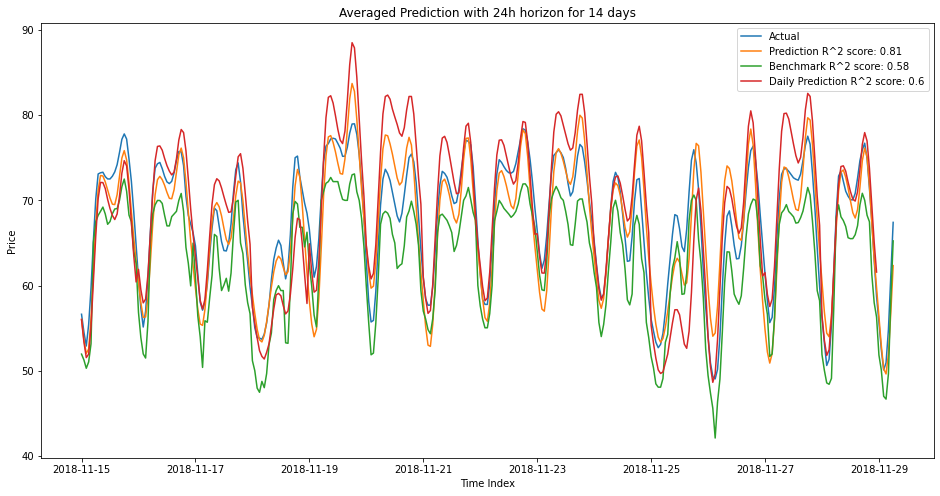

In [114]:
fig = plt.figure(figsize=(16,8))
plt.plot(extended_eval_df['Actual'],label = 'Actual')
plt.plot(extended_eval_df['Prediction'], label= f'Prediction R^2 score: {round(r2_test,2)}')
plt.plot(extended_eval_df['Benchmark'], label = f'Benchmark R^2 score: {round(r2_bench,2)}')
plt.plot(df_pred_24h['total'][:-7], label = f'Daily Prediction R^2 score: {round(r2_24h,2)}')
plt.xlabel('Time Index')
plt.ylabel('Price')
plt.title('Averaged Prediction with 24h horizon for 14 days')
plt.legend()
# plt.xlim(idx_test[0],idx_test[0]+timedelta(hours=24*14-1))